# 라이브러리 및 데이터 셋팅

In [ ]:
# import tensorflow as tf
from keras.datasets import cifar100
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import os 
import cv2
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dense 
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model

# 전처리

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

169001437/169001437 [==============================] - 29s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

In [ ]:
X_train[:,:,:,0].mean(), X_train[:,:,:,1].mean(), X_train[:,:,:,2].mean()

(129.1949991455078, 124.000590625, 112.37299807128906)

- 이미지 리사이즈 => 랜덤 크롭 / 랜덤 좌우반전 / 랜덤 RGB값 변경

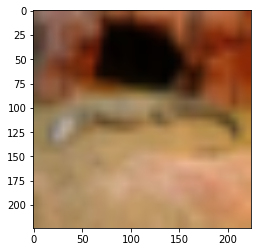

In [ ]:
img = tf.image.resize(X_train[0], [224,224])
plt.imshow(img/255)



```
img = tf.image.resize(X_train[0], [224,224])
plt.imshow(img)

=> WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```
이렇게 실행하면 아래와 같은 Warning이 뜨면서 백지만 뜸.

https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

위에 참고해서 plt.imshow(img) => plt.imshow(img/255)

이렇게 바꾸면 잘나온다 왜일까??


```
plt.imshow(np.array(img).astype(np.uint8)) 얘도 잘됨
```

=> [0..1] for floats or [0..255] for integers

=> 아 0\~1 사이 실수이거나 0\~255사이 정수가 오면 되는데 얘는 0~255 사이 dtype=float32, 실수라서 matplotlib이 인식을 못했음


랜덤크롭 : https://blog.roboflow.com/why-and-how-to-implement-random-crop-data-augmentation/

랜덤 RGB shift : https://runebook.dev/ko/docs/tensorflow/image/random_hue

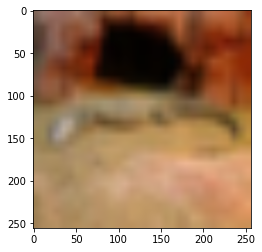

In [ ]:
img = tf.image.resize(X_train[0], [256,256])
plt.imshow(img/255)

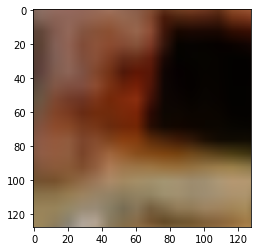

In [ ]:
cropped_img = tf.image.random_crop(img, [128,128,3])
plt.imshow(cropped_img/255)

- 고정된 scale에서 랜덤으로 크롭하고 random horizontal flip, random RGB colour shift

## single_scale_preprocessing

In [ ]:
# 결과로 크롭,플립,RGB변형된 3장의 이미지를 출력
def single_scale_preprocessing(img, label):
    scale=256
    resized_img = tf.image.resize(img, [scale,scale])
    cropped_img = tf.image.random_crop(resized_img, [224,224,3])
    flipped_img = tf.image.random_flip_left_right(cropped_img,5)
    shift_img = tf.image.random_hue(cropped_img, 0.5)

    aug_img = [cropped_img, flipped_img, shift_img]
    labels = [label, label, label]
    aug_img = np.array(aug_img)/255
    labels = np.array(labels)

    return aug_img, labels

In [ ]:
aug_imgs, labels = single_scale_preprocessing(X_train[0], y_train[0])

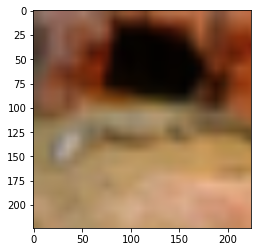

In [ ]:
plt.imshow(aug_imgs[0])

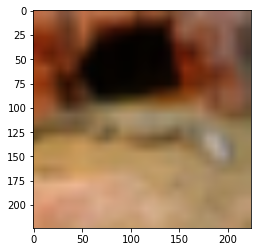

In [ ]:
plt.imshow(aug_imgs[1])

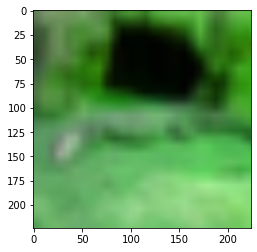

In [ ]:
 plt.imshow(aug_imgs[2])

In [ ]:
def single_scale_preprocessing(img, label):
    scale=256
    random = np.random.randint(0,3)

    resized_img = tf.image.resize(img, [scale,scale])
    cropped_img = tf.image.random_crop(resized_img, [224,224,3])
    
    if random == 0:
        image = tf.image.random_crop(resized_img, [224,224,3])
    elif random == 1:
        image = tf.image.random_flip_left_right(cropped_img,5)
    elif random == 2:
        image = tf.image.random_hue(cropped_img, 0.5)

    # image = image/255 
    image = image-127.5/127.5 # 255로 나누어서 정규화하는건 성능이 안나오고... 제로센터링을 해주니 성능이 잘 나오네..??
    # 채널당 평균값을 픽셀에서 빼주기
    # image = image.numpy()
    # r = image[:,:,0] - image[:,:,0].mean()
    # g = image[:,:,1] - image[:,:,1].mean()
    # b = image[:,:,2] - image[:,:,2].mean()
    # mean_img = np.stack([r,g,b]) # 쌓으면 (3, 32, 32) 형태가 나와서 
    # image = np.transpose(mean_img, (1, 2, 0)) # reshape, transpose로 (32, 32, 3) 순서를 바꿔줌

    return image, label

In [ ]:
def test_preprocessing(img, label):
    image = tf.image.resize(img, [224,224])
    # image = resized_img/255
    image = image-127.5/127.5

    return image, label

- 3,32,32 => 32,32,3 : http://taewan.kim/post/transpose_reshape/
---
- 이미지에서 채널당 평균값을 구해서 빼주고 stack시키고 transpose하려 했는데 tf.image를 통해서 나오는 값은 넘파이로 처리가 안되는듯 하다

    => .numpy() 사용하면 넘파이로 바뀌어서 넘파이 연산 가능. 하지만 처리하고나면 224,224,3 이 아닌 128,128,3이 나온다....

    => 함수 중간에 입력값이 잘못되어 있었음. 224x224x3으로 크롭된 이미지가 들어가야하는데 이게 위에서 명시되어 있지 않았다. 논문의 방법대로 평균값을 빼주긴 했는데 일단 돌려보고 성능확인해보자

    => opencv를 쓸까????

- cv로 랜덤크롭하는 방법... 그냥 크롭을 사용하되 시작 픽셀만 범위를 줘서 랜덤값이 나오게 하면 랜덤 크롭이 되는게 아닐까? 

In [ ]:
aug_imgs, labels = single_scale_preprocessing(X_train[0], y_train[0])
aug_imgs.shape

TensorShape([224, 224, 3])



```
AttributeError: 'Tensor' object has no attribute 'numpy'
```

- 예상은 했는데... tf.data를 사용해 텐서형태로 처리하는거라 중간에 넘파이로 계산하는 과정을 넣으면 에러가 날거 같긴 했다..

- RGB 평균값 빼주는 방법 찾아보자

## multi-scale preprocessing

In [ ]:
np.random.randint(256,512)

In [ ]:
def multi_scale_preprocessing(img, label):
    scale = np.random.randint(256,512)
    random = np.random.randint(0,3)

    resized_img = tf.image.resize(img, [scale,scale])
    cropped_img = tf.image.random_crop(resized_img, [224,224,3])
    
    if random == 0:
        image = tf.image.random_crop(resized_img, [224,224,3])
    elif random == 1:
        image = tf.image.random_flip_left_right(cropped_img,5)
    elif random == 2:
        image = tf.image.random_hue(cropped_img, 0.5)

    # image = image/255 
    image = image-127.5/127.5 # 255로 나누어서 정규화하는건 성능이 안나오고... 제로센터링을 해주니 성능이 잘 나오네..??
    # 채널당 평균값을 픽셀에서 빼주기
    # image = image.numpy()
    # r = image[:,:,0] - image[:,:,0].mean()
    # g = image[:,:,1] - image[:,:,1].mean()
    # b = image[:,:,2] - image[:,:,2].mean()
    # mean_img = np.stack([r,g,b]) # 쌓으면 (3, 32, 32) 형태가 나와서 
    # image = np.transpose(mean_img, (1, 2, 0)) # reshape, transpose로 (32, 32, 3) 순서를 바꿔줌

    return image, label

## tf.data로 데이터셋 생성

In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.map(single_scale_preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(single_scale_preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(test_preprocessing).batch(batch_size).prefetch(1)

- 테스트셋은 어떻게 만들지?? 그냥 단순하게 만드는게 아니라 논문에선 테스트 시 모델 구조도 다른데...음...
    
    => 일단은 별다른 처리 없이 만듬

In [ ]:
for i,j in train_dataset.take(1):
    print(i), print(j)

# 모델링 - 학습 및 검증은 VGG16, 19만

## Single Sclae (S=256)

## VGG16 (conv 1x1) 

In [ ]:
input_size = [224,224,3]

vgg_C = Sequential([
    layers.Conv2D(64,3,padding='same', activation='relu', input_shape=input_size),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,1,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,1,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,1,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax'),
])

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_vgg_C.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)

vgg_C.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = vgg_C.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[es,mc,reduce_lr])

In [ ]:
vgg_C.evaluate(test_dataset)

## VGG16 - single_scale_preprocessing (S = 256 )

In [ ]:
input_size = [224,224,3]

vgg_C = Sequential([
    layers.Conv2D(64,3,padding='same', activation='relu', input_shape=input_size),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax'),
])

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_vgg_C.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)

vgg_C.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = vgg_C.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[es,mc,reduce_lr])

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 4.5363 - accuracy: 0.0169
Epoch 1: val_loss improved from inf to 4.32767, saving model to /content/drive/MyDrive/best_vgg_C.h5
1250/1250 [==============================] - 646s 516ms/step - loss: 4.5363 - accuracy: 0.0169 - val_loss: 4.3277 - val_accuracy: 0.0405 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 4.2415 - accuracy: 0.0498
Epoch 2: val_loss improved from 4.32767 to 4.04221, saving model to /content/drive/MyDrive/best_vgg_C.h5
1250/1250 [==============================] - 644s 515ms/step - loss: 4.2415 - accuracy: 0.0498 - val_loss: 4.0422 - val_accuracy: 0.0722 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 4.0034 - accuracy: 0.0825
Epoch 3: val_loss improved from 4.04221 to 3.80414, saving model to /content/drive/MyDrive/best_vgg_C.h5
1250/1250 [==============================] - 645s 516ms/step - loss: 4.0034 - accuracy: 0.08

In [ ]:
model = load_model('/content/drive/MyDrive/best_vgg16.h5')

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_vgg16.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[es,mc,reduce_lr])

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5218 - accuracy: 0.6036
Epoch 1: val_loss improved from inf to 1.99121, saving model to /content/drive/MyDrive/best_vgg16.h5
1250/1250 [==============================] - 657s 512ms/step - loss: 1.5218 - accuracy: 0.6036 - val_loss: 1.9912 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.2790 - accuracy: 0.6565
Epoch 2: val_loss improved from 1.99121 to 1.85931, saving model to /content/drive/MyDrive/best_vgg16.h5
1250/1250 [==============================] - 643s 514ms/step - loss: 1.2790 - accuracy: 0.6565 - val_loss: 1.8593 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 1.1129 - accuracy: 0.6921
Epoch 3: val_loss improved from 1.85931 to 1.85889, saving model to /content/drive/MyDrive/best_vgg16.h5
1250/1250 [==============================] - 644s 515ms/step - loss: 1.1129 - accuracy: 0.69

In [ ]:
model.evaluate(test_dataset) # scale=256

313/313 [==============================] - 46s 147ms/step - loss: 1.9442 - accuracy: 0.5146


[1.9442195892333984, 0.5145999789237976]

- VGG16 - Single Scale ( S = 256 ) : loss: 1.9442 - accuracy: 0.5146

## VGG19 - single_scale_preprocessing (S = 256 )

In [ ]:
input_size = [224,224,3]

vgg_19 = Sequential([
    layers.Conv2D(64,3,padding='same', activation='relu', input_shape=input_size),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax'),
])

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_vgg19.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)

vgg_19.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = vgg_19.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[es,mc,reduce_lr])

In [ ]:
model = load_model('/content/drive/MyDrive/best_vgg19.h5')

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_vgg19.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks=[es,mc,reduce_lr])

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5025 - accuracy: 0.5849
Epoch 1: val_loss improved from inf to 2.22329, saving model to /content/drive/MyDrive/best_vgg19.h5
1250/1250 [==============================] - 757s 592ms/step - loss: 1.5025 - accuracy: 0.5849 - val_loss: 2.2233 - val_accuracy: 0.4401 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.4096 - accuracy: 0.6112
Epoch 2: val_loss improved from 2.22329 to 2.20360, saving model to /content/drive/MyDrive/best_vgg19.h5
1250/1250 [==============================] - 738s 590ms/step - loss: 1.4096 - accuracy: 0.6112 - val_loss: 2.2036 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.6362
Epoch 3: val_loss did not improve from 2.20360
1250/1250 [==============================] - 729s 583ms/step - loss: 1.3033 - accuracy: 0.6362 - val_loss: 2.2612 - val_accuracy: 0.4511 - lr: 0.0010


In [ ]:
model.evaluate(test_dataset)

313/313 [==============================] - 59s 190ms/step - loss: 2.1665 - accuracy: 0.4574


[2.166492462158203, 0.45739999413490295]